# Import de la db

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt

In [15]:
df = pd.read_csv("SBAnational.csv")

/tmp/ipykernel_6610/3536806131.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("SBAnational.csv")


In [16]:
df.head(1)

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,...,N,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00"


## Gerer les targets null

In [17]:
df["MIS_Status"].isnull().sum()

np.int64(1997)

In [18]:
df_without_null = df[df["MIS_Status"].notnull()]

In [21]:
df['ChgOffDate_null'] = df['ChgOffDate'].isnull().astype(int)  # 1 si null, 0 sinon
df['MIS_Status_numeric'] = df['MIS_Status'].map({'P I F': 1, 'CHGOFF': 0})  # 1 = remboursé, 0 = défaut
correlation = df[['ChgOffDate_null', 'MIS_Status_numeric']].corr()
print(correlation)


                    ChgOffDate_null  MIS_Status_numeric
ChgOffDate_null            1.000000            0.981465
MIS_Status_numeric         0.981465            1.000000


On a une énorme corrélation. On va remplacer les targets null en prenant en compte ce ChgOffDate

In [20]:
df['MIS_Status'] = df.apply(
    lambda row: 'P I F' if pd.isna(row['ChgOffDate']) else 'CHGOFF' 
    if pd.isna(row['MIS_Status']) else row['MIS_Status'],
    axis=1
)

## Format des colonnes

Suppression des colonnes de targets leakings et d'autres colonnes inutile :

In [23]:
df = df.drop(["LoanNr_ChkDgt", "Name", "ChgOffDate", "DisbursementDate", "BalanceGross", "ChgOffPrinGr", "SBA_Appv"], axis=1)
df_without_null = df_without_null.drop(["LoanNr_ChkDgt", "Name", "ChgOffDate", "DisbursementDate", "BalanceGross", "ChgOffPrinGr", "SBA_Appv"], axis=1)

In [24]:
df.dtypes

City                   object
State                  object
Zip                     int64
Bank                   object
BankState              object
NAICS                   int64
ApprovalDate           object
ApprovalFY             object
Term                    int64
NoEmp                   int64
NewExist              float64
CreateJob               int64
RetainedJob             int64
FranchiseCode           int64
UrbanRural              int64
RevLineCr              object
LowDoc                 object
DisbursementGross      object
MIS_Status             object
GrAppv                 object
ChgOffDate_null         int64
MIS_Status_numeric      int64
dtype: object

In [26]:
print(df.map(lambda x: isinstance(x, str)).sum())

City                  899134
State                 899150
Zip                        0
Bank                  897605
BankState             897598
NAICS                      0
ApprovalDate          899164
ApprovalFY            131072
Term                       0
NoEmp                      0
NewExist                   0
CreateJob                  0
RetainedJob                0
FranchiseCode              0
UrbanRural                 0
RevLineCr             894636
LowDoc                896582
DisbursementGross     899164
MIS_Status            899164
GrAppv                899164
ChgOffDate_null            0
MIS_Status_numeric         0
dtype: int64


In [27]:
for col in df.select_dtypes(include=['object']).columns:
    print(f"🔍 {col}: {df[col].unique()}")

🔍 City: ['EVANSVILLE' 'NEW PARIS' 'BLOOMINGTON' ... 'MURFRECSBORO' 'E WENALCHEE'
 'SO. OZONE PARK']
🔍 State: ['IN' 'OK' 'FL' 'CT' 'NJ' 'NC' 'IL' 'RI' 'TX' 'VA' 'TN' 'AR' 'MN' 'MO'
 'MA' 'CA' 'SC' 'LA' 'IA' 'OH' 'KY' 'MS' 'NY' 'MD' 'PA' 'OR' 'ME' 'KS'
 'MI' 'AK' 'WA' 'CO' 'MT' 'WY' 'UT' 'NH' 'WV' 'ID' 'AZ' 'NV' 'WI' 'NM'
 'GA' 'ND' 'VT' 'AL' 'NE' 'SD' 'HI' 'DE' 'DC' nan]
🔍 Bank: ['FIFTH THIRD BANK' '1ST SOURCE BANK' 'GRANT COUNTY STATE BANK' ...
 'FIRST ILLINOIS BANK' 'COLORADO COMMUNITY FIRST STATE' 'DEPCO']
🔍 BankState: ['OH' 'IN' 'OK' 'FL' 'DE' 'SD' 'AL' 'CT' 'GA' 'OR' 'MN' 'RI' 'NC' 'TX'
 'MD' 'NY' 'TN' 'SC' 'MS' 'MA' 'LA' 'IA' 'VA' 'CA' 'IL' 'KY' 'PA' 'MO'
 'WA' 'MI' 'UT' 'KS' 'WV' 'WI' 'AZ' 'NJ' 'CO' 'ME' 'NH' 'AR' 'ND' 'MT'
 'ID' nan 'WY' 'NM' 'DC' 'NV' 'NE' 'PR' 'HI' 'VT' 'AK' 'GU' 'AN' 'EN' 'VI']
🔍 ApprovalDate: ['28-Feb-97' '2-Jun-80' '7-Feb-06' ... '24-Feb-97' '25-Feb-97' '27-Feb-97']
🔍 ApprovalFY: [1997 1980 2006 1998 1999 2000 2001 1972 2003 2004 1978 1979 1981 2005
 1962 1

In [41]:
df["Bank"].unique()

array(['FIFTH THIRD BANK', '1ST SOURCE BANK', 'GRANT COUNTY STATE BANK',
       ..., 'FIRST ILLINOIS BANK', 'COLORADO COMMUNITY FIRST STATE',
       'DEPCO'], shape=(5803,), dtype=object)

Trop de valeur on ne prend pas cette colonne...

### Champs dates

In [ ]:
df['ApprovalDate'] = pd.to_datetime(df['ApprovalDate'], format='%d-%b-%y')

df['ApprovalDate'] = df['ApprovalDate'].apply(
    lambda x: x - pd.DateOffset(years=100) if x.year > 2014 else x)

In [28]:
df['ApprovalFY'] = pd.to_numeric(df['ApprovalFY'], errors='coerce')
df['ApprovalFY'] = df['ApprovalFY'].astype('Int64')  # Int64 permet d'avoir des NaN

### Champs Moulaga

In [29]:
cols_to_convert = ['GrAppv', 'DisbursementGross']

for col in cols_to_convert:
    df[col] = df[col].astype(str)  # S'assure que c'est une string
    df[col] = df[col].str.replace('[\$,]', '', regex=True)  # Retire $ et ,
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Convertit en float

In [30]:
print(df[cols_to_convert].dtypes) 

GrAppv               float64
DisbursementGross    float64
dtype: object


# Preparation des données :

In [31]:
features_of_interest = [
    "State",
    "NAICS",
    "ApprovalDate",
    "Term",
    "NoEmp",
    "NewExist",
    'CreateJob', 
    'RetainedJob',
    'FranchiseCode', 
    'UrbanRural', 
    'RevLineCr', 
    'LowDoc',
    'DisbursementGross', 
    'GrAppv'
    ]

data = df

target_name = "MIS_Status"
X, y = (
    data[features_of_interest],
    data[target_name]
)

In [32]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 899164 entries, 0 to 899163
Series name: MIS_Status
Non-Null Count   Dtype 
--------------   ----- 
899164 non-null  object
dtypes: object(1)
memory usage: 6.9+ MB


<Axes: >

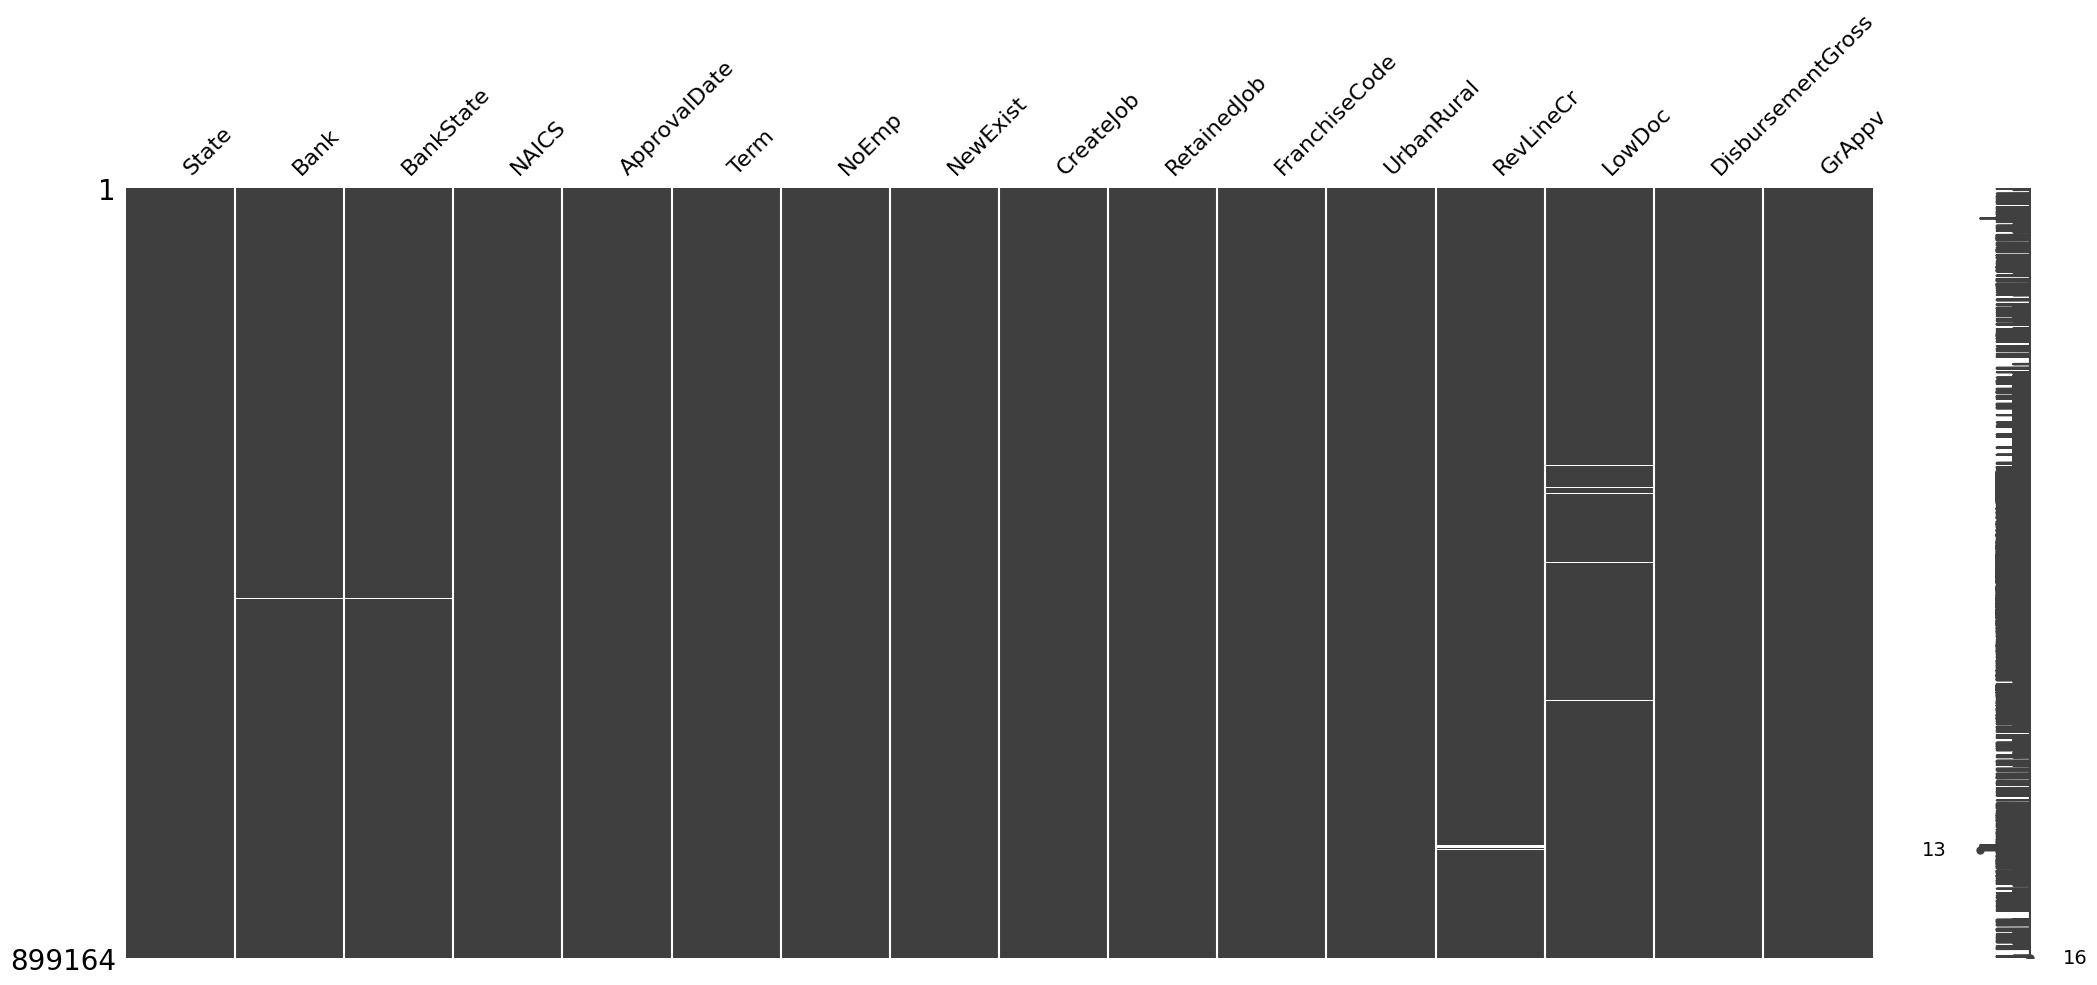

In [33]:
import missingno as msno
msno.matrix(X)

In [34]:
print(X.isnull().sum())

State                  14
Bank                 1559
BankState            1566
NAICS                   0
ApprovalDate            0
Term                    0
NoEmp                   0
NewExist              136
CreateJob               0
RetainedJob             0
FranchiseCode           0
UrbanRural              0
RevLineCr            4528
LowDoc               2582
DisbursementGross       0
GrAppv                  0
dtype: int64


In [35]:
pd.crosstab(X["State"], X["BankState"])

BankState,AK,AL,AN,AR,AZ,CA,CO,CT,DC,DE,...,TN,TX,UT,VA,VI,VT,WA,WI,WV,WY
State,,,,,,,,,,,,,,,,,,,,,
AK,1414,0,0,3,0,144,3,3,5,0,...,0,13,2,50,0,1,89,0,0,0
AL,1,5395,0,9,1,629,4,5,4,32,...,98,91,14,270,0,0,0,0,0,0
AR,0,97,0,4772,2,208,1,4,13,1,...,37,112,20,194,0,0,0,0,0,0
AZ,3,441,0,0,3709,1918,185,81,88,2,...,9,556,168,422,0,0,1,61,0,0
CA,2,43,0,2,58,76477,1997,127,1305,9,...,25,4505,511,3264,0,0,103,7,0,1
CO,1,311,0,5,19,1979,7620,17,95,3,...,7,494,369,684,0,0,1,8,0,32
CT,0,3,0,0,0,407,1,5486,9,544,...,5,60,6,320,0,4,0,1,0,0
DC,0,0,0,0,0,481,1,10,192,80,...,0,15,2,147,0,0,0,0,0,0
DE,0,1,1,1,0,126,7,2,12,990,...,1,14,2,51,0,0,0,0,2,0


In [36]:
print(y.isnull().sum())

0


In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.1, random_state=42, stratify=y)

## Preprocessing

Pour ne pas faire exploser le nombre de colonnes je vais utiliser un ordinal encoding plutot qu'un OneHotEncoder. J'ai la sensation que ça ne vas pas trop perturber XGBoost...

In [ ]:
preprocessor = pipeline(AgeTransformer("age"), BmiTransformer("bmi"), ColumnTransformer(
    [("categorical", OneHotEncoder(), categorical_column),
    ("ordinal", OrdinalEncoder(), ordinal_column),
    ("numeric", RobustScaler(), numerical_column),
    ],
    remainder="passthrough",
))

linear_model = make_pipeline(preprocessor, PolynomialFeatures(2), LinearRegression())
linear_model.fit(X_train,y_train)